In [1]:
# TODO use GAN?

import os, copy, torch, numpy as np
from torch.utils.data import DataLoader, Dataset
from torchvision.io import read_image
from torchvision.transforms import v2
from torchvision import transforms
import torch
import torch.nn as nn
from tqdm import tqdm 
from PIL import Image

from matplotlib import pyplot as plt

device = "cuda"

In [2]:
DATASETS = "dataset/"
FRLG = DATASETS + "frlg/"
HUE = DATASETS + "frlg_hue/"

ds = os.listdir(HUE)

np.random.shuffle(ds)
test, val = ds[20:], ds[:20]

len(test), len(val)

(366, 20)

In [3]:
class SatelliteDataset(Dataset):
    def __init__(self, list):
        toTensor = transforms.ToTensor()
        self.img_list = []

        for i in list:
            hue = Image.open(HUE + i).convert("RGB")
            hue = toTensor(hue)

            img = Image.open(FRLG + i).convert("RGBA")
            img = toTensor(img)
            alpha = img[[3]]
            img = img[[0,1,2]] * alpha
            img += 1 - alpha

            img = torch.concatenate((img, hue), dim=0)
            self.img_list.append(img)

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        return self.img_list[idx]

BS = 8

train_ds = SatelliteDataset(test)
train_dl = DataLoader(train_ds, batch_size=BS, shuffle=True)

val_ds = SatelliteDataset(val)
val_dl = DataLoader(val_ds, batch_size=len(val_ds), shuffle=True)

In [4]:
class RandomNoise(nn.Module):
    def __init__(self, std=0.1):
        super().__init__()
        self.std = std

    def forward(self, x):
        std = torch.rand(1).item() * self.std
        noise = torch.randn_like(x) * std
        return x + noise

train_transform1 = v2.Compose([
    #v2.RandomCrop((60, 60)),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomVerticalFlip(p=0.5),
    v2.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.5),
    v2.RandomGrayscale(p=0.2),
])

train_transform2 = v2.Compose([
    v2.RandomApply([RandomNoise(std=0.04)], p = 0.5),
])

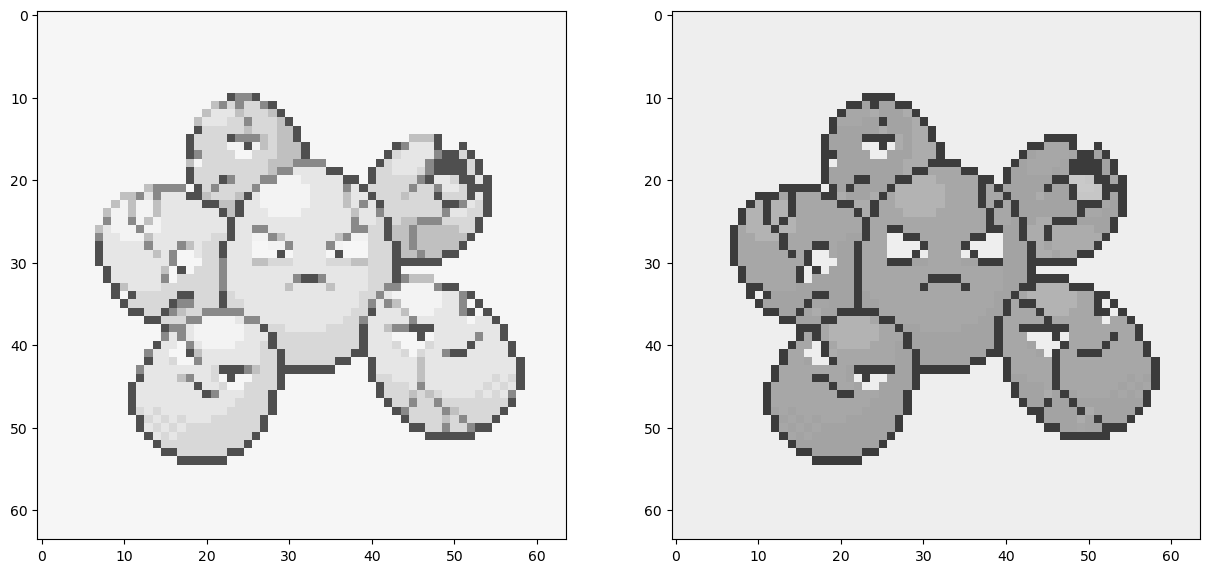

In [5]:
data = next(iter(train_dl))
data = data.view(BS, 2, 3, 64, 64)
data = torch.stack([train_transform1(x) for x in data])

im = data[:, 0]
lb = data[:, 1]

im = torch.stack([train_transform2(x) for x in im])

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
axes[0].imshow(im[0].permute(1, 2, 0).numpy())
axes[1].imshow(lb[0].permute(1, 2, 0).numpy())
plt.show()

In [6]:
from auto_encoder import PAutoE

model = PAutoE().to(device)

In [7]:
#https://www.mdpi.com/2072-4292/11/9/1015/pdf
#@torch.compile
def ssim_loss(pred, target):
    mean_pred = torch.mean(pred, dim=(1, 2, 3))
    mean_target = torch.mean(target, dim=(1, 2, 3))

    var_pred = torch.var(pred, dim=(1, 2, 3))
    var_target = torch.var(target, dim=(1, 2, 3))

    cov = torch.mean(pred * target, dim=(1, 2, 3)) - mean_pred * mean_target

    c1 = 0.01 ** 2
    c2 = 0.03 ** 2

    ssim = (2 * mean_pred * mean_target + c1) * (2 * cov + c2) 
    ssim /= (mean_pred ** 2 + mean_target ** 2 + c1) * (var_pred + var_target + c2)

    return (1 - ssim) / 2

Epoch 0. Loss: 0.3365: 100%|██████████| 46/46 [00:01<00:00, 23.08it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.26304 *


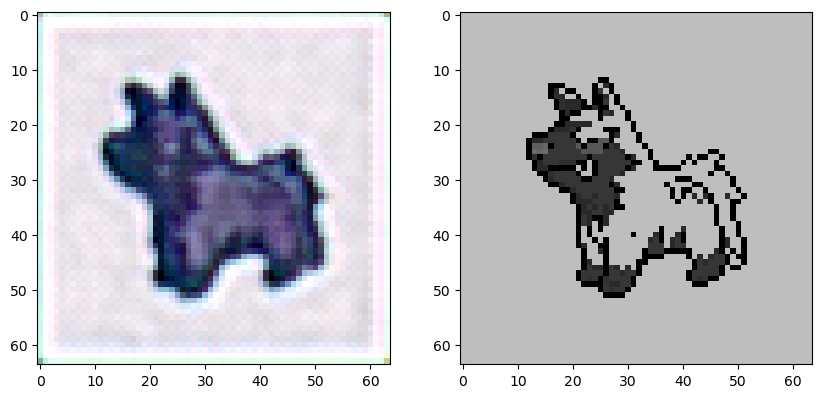

Epoch 1. Loss: 0.0955: 100%|██████████| 46/46 [00:01<00:00, 30.10it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.13141 *


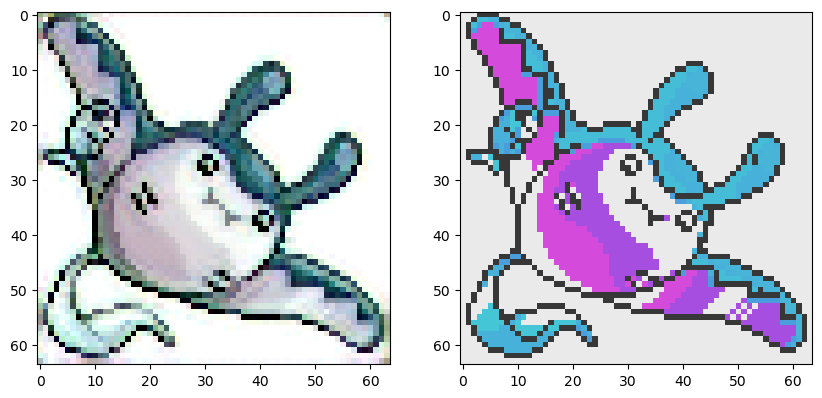

Epoch 2. Loss: 0.1380: 100%|██████████| 46/46 [00:01<00:00, 29.77it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.12601 *


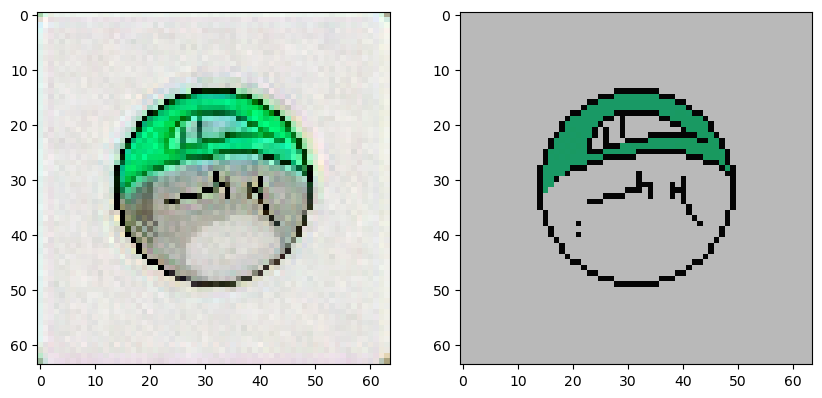

Epoch 3. Loss: 0.2088: 100%|██████████| 46/46 [00:01<00:00, 29.93it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.10755 *


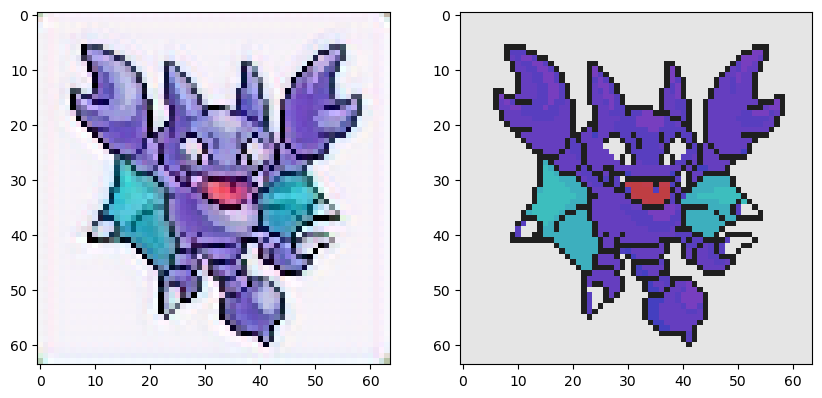

Epoch 4. Loss: 0.1141: 100%|██████████| 46/46 [00:01<00:00, 30.25it/s]


0.11510


Epoch 5. Loss: 0.1202: 100%|██████████| 46/46 [00:01<00:00, 29.48it/s]


0.10916


Epoch 6. Loss: 0.1023: 100%|██████████| 46/46 [00:01<00:00, 30.23it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.10251 *


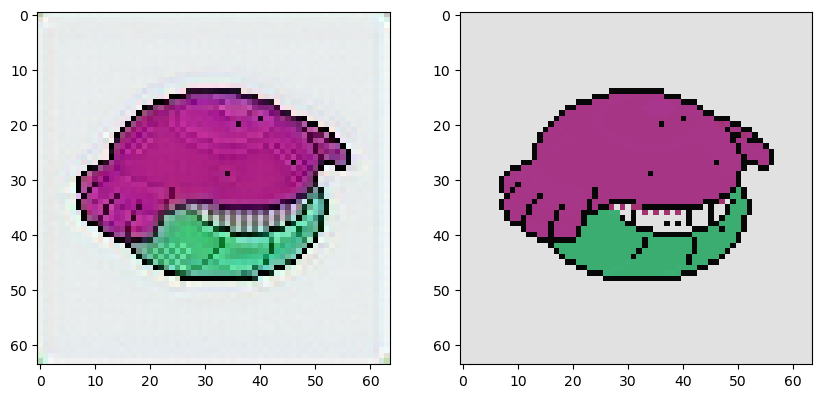

Epoch 7. Loss: 0.0761: 100%|██████████| 46/46 [00:01<00:00, 29.78it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.09986 *


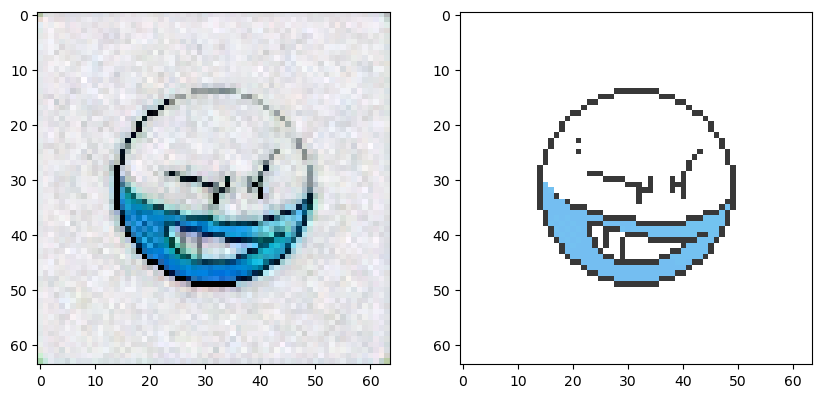

Epoch 8. Loss: 0.1038: 100%|██████████| 46/46 [00:01<00:00, 29.12it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.09880 *


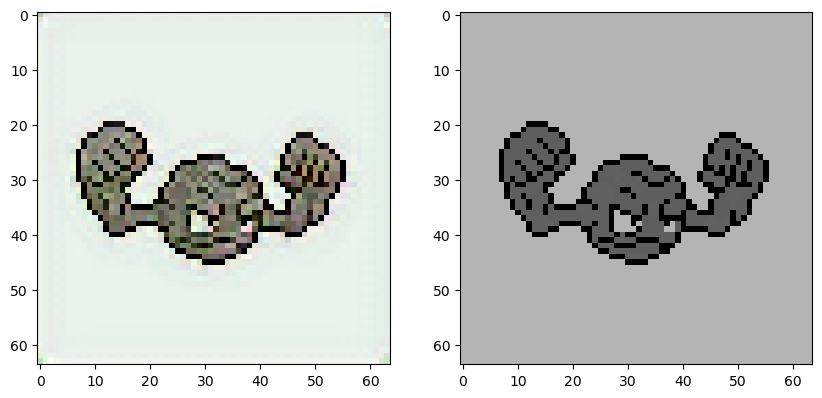

Epoch 9. Loss: 0.1114: 100%|██████████| 46/46 [00:01<00:00, 30.07it/s]


0.10414


Epoch 10. Loss: 0.0767: 100%|██████████| 46/46 [00:01<00:00, 30.07it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.08501 *


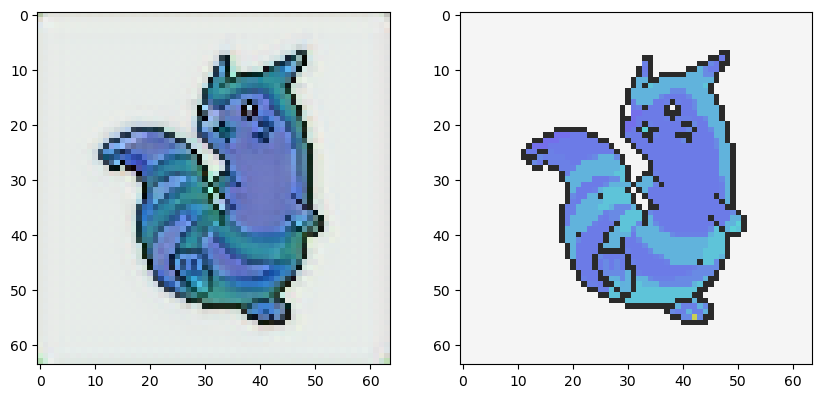

Epoch 11. Loss: 0.0953: 100%|██████████| 46/46 [00:01<00:00, 29.58it/s]


0.08930


Epoch 12. Loss: 0.0889: 100%|██████████| 46/46 [00:01<00:00, 30.13it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.08427 *


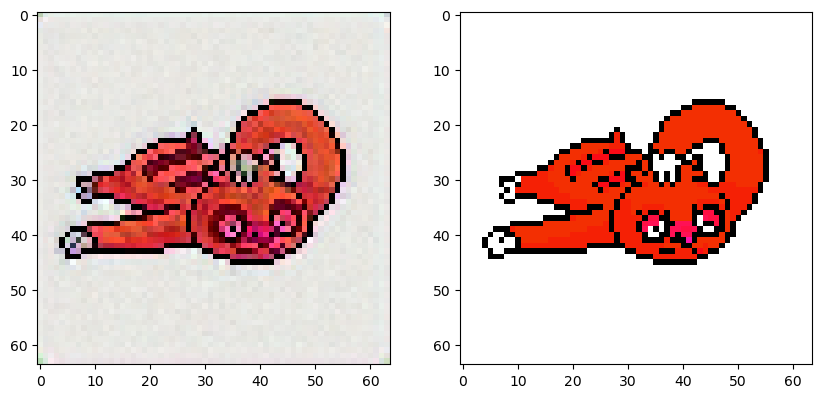

Epoch 13. Loss: 0.1134: 100%|██████████| 46/46 [00:01<00:00, 30.01it/s]


0.08926


Epoch 14. Loss: 0.0864: 100%|██████████| 46/46 [00:01<00:00, 29.27it/s]


0.08811


Epoch 15. Loss: 0.0825: 100%|██████████| 46/46 [00:01<00:00, 29.72it/s]


0.09293


Epoch 16. Loss: 0.0692: 100%|██████████| 46/46 [00:01<00:00, 30.00it/s]


0.09176


Epoch 17. Loss: 0.0854: 100%|██████████| 46/46 [00:01<00:00, 29.58it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.08321 *


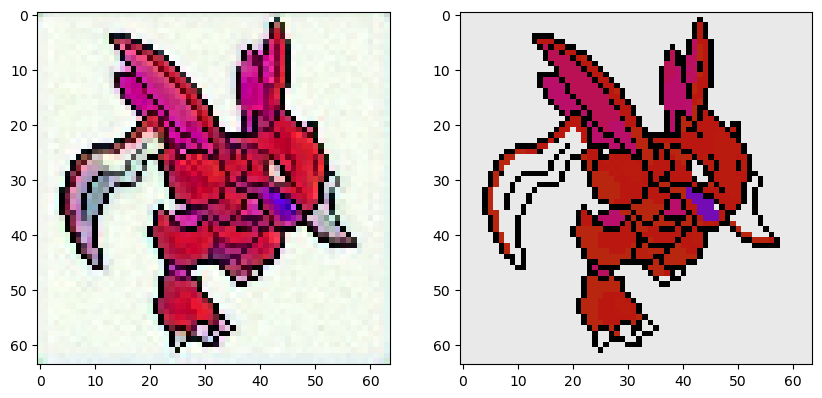

Epoch 18. Loss: 0.1103: 100%|██████████| 46/46 [00:01<00:00, 30.24it/s]


0.08553


Epoch 19. Loss: 0.1098: 100%|██████████| 46/46 [00:01<00:00, 30.17it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.06751 *


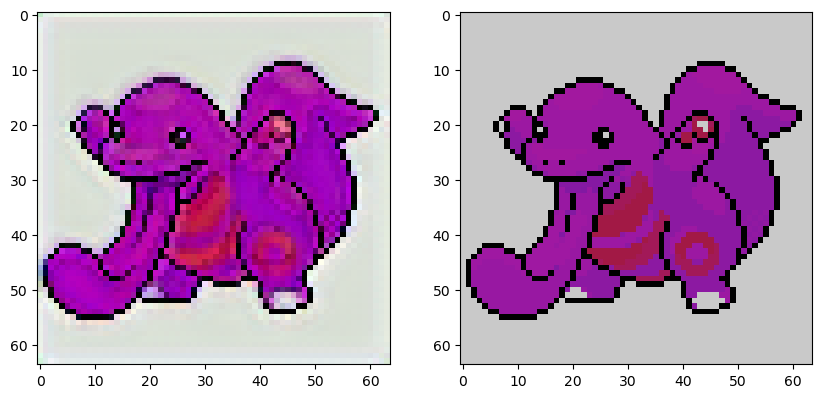

Epoch 20. Loss: 0.0874: 100%|██████████| 46/46 [00:01<00:00, 29.16it/s]


0.08638


Epoch 21. Loss: 0.0545: 100%|██████████| 46/46 [00:01<00:00, 30.00it/s]


0.07321


Epoch 22. Loss: 0.0651: 100%|██████████| 46/46 [00:01<00:00, 30.12it/s]


0.07386


Epoch 23. Loss: 0.0939: 100%|██████████| 46/46 [00:01<00:00, 29.55it/s]


0.07823


Epoch 24. Loss: 0.0663: 100%|██████████| 46/46 [00:01<00:00, 30.18it/s]


0.08289


Epoch 25. Loss: 0.0902: 100%|██████████| 46/46 [00:01<00:00, 30.18it/s]


0.07237


Epoch 26. Loss: 0.0948: 100%|██████████| 46/46 [00:01<00:00, 29.51it/s]


0.08754


Epoch 27. Loss: 0.1026: 100%|██████████| 46/46 [00:01<00:00, 30.25it/s]


0.08094


Epoch 28. Loss: 0.0753: 100%|██████████| 46/46 [00:01<00:00, 30.16it/s]


0.08710


Epoch 29. Loss: 0.0728: 100%|██████████| 46/46 [00:01<00:00, 29.36it/s]


0.07685


Epoch 30. Loss: 0.0735: 100%|██████████| 46/46 [00:01<00:00, 29.66it/s]


0.06769


Epoch 31. Loss: 0.0818: 100%|██████████| 46/46 [00:01<00:00, 30.21it/s]


0.07476


Epoch 32. Loss: 0.0658: 100%|██████████| 46/46 [00:01<00:00, 29.15it/s]


0.06869


Epoch 33. Loss: 0.0767: 100%|██████████| 46/46 [00:01<00:00, 30.05it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.05916 *


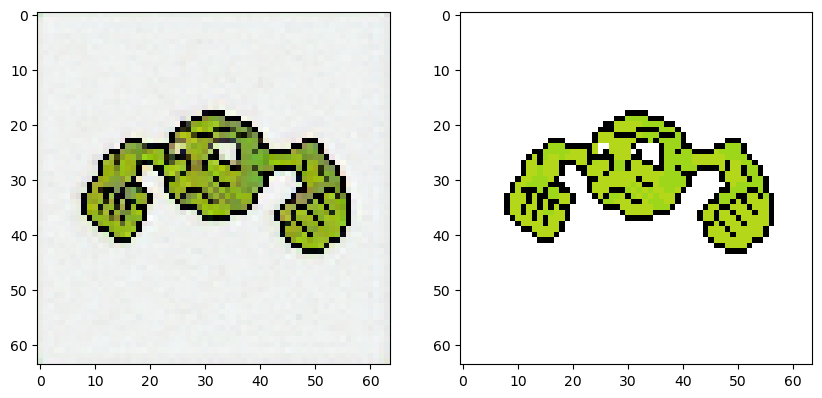

Epoch 34. Loss: 0.0628: 100%|██████████| 46/46 [00:01<00:00, 29.28it/s]


0.07433


Epoch 35. Loss: 0.0685: 100%|██████████| 46/46 [00:01<00:00, 29.65it/s]


0.08183


Epoch 36. Loss: 0.1106: 100%|██████████| 46/46 [00:01<00:00, 29.97it/s]


0.08209


Epoch 37. Loss: 0.0691: 100%|██████████| 46/46 [00:01<00:00, 29.92it/s]


0.06743


Epoch 38. Loss: 0.0739: 100%|██████████| 46/46 [00:01<00:00, 29.47it/s]


0.06470


Epoch 39. Loss: 0.0839: 100%|██████████| 46/46 [00:01<00:00, 29.74it/s]


0.06794


Epoch 40. Loss: 0.0861: 100%|██████████| 46/46 [00:01<00:00, 26.67it/s]


0.06472


Epoch 41. Loss: 0.0614: 100%|██████████| 46/46 [00:01<00:00, 26.97it/s]


0.07160


Epoch 42. Loss: 0.0662: 100%|██████████| 46/46 [00:01<00:00, 29.82it/s]


0.06128


Epoch 43. Loss: 0.0709: 100%|██████████| 46/46 [00:01<00:00, 31.79it/s]


0.05997


Epoch 44. Loss: 0.0551: 100%|██████████| 46/46 [00:01<00:00, 31.37it/s]


0.06535


Epoch 45. Loss: 0.0899: 100%|██████████| 46/46 [00:01<00:00, 30.93it/s]


0.06783


Epoch 46. Loss: 0.0873: 100%|██████████| 46/46 [00:01<00:00, 31.86it/s]


0.07564


Epoch 47. Loss: 0.0639: 100%|██████████| 46/46 [00:01<00:00, 30.41it/s]


0.07525


Epoch 48. Loss: 0.0514: 100%|██████████| 46/46 [00:01<00:00, 32.10it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.05702 *


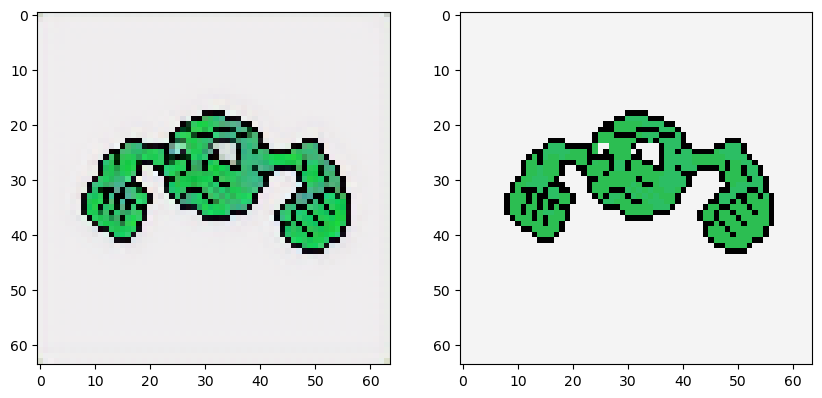

Epoch 49. Loss: 0.0738: 100%|██████████| 46/46 [00:01<00:00, 32.25it/s]


0.07101


Epoch 50. Loss: 0.0764: 100%|██████████| 46/46 [00:01<00:00, 31.89it/s]


0.06179


Epoch 51. Loss: 0.0421: 100%|██████████| 46/46 [00:01<00:00, 32.09it/s]


0.05763


Epoch 52. Loss: 0.0521: 100%|██████████| 46/46 [00:01<00:00, 32.24it/s]


0.06292


Epoch 53. Loss: 0.1492: 100%|██████████| 46/46 [00:01<00:00, 31.26it/s]


0.06531


Epoch 54. Loss: 0.0774: 100%|██████████| 46/46 [00:01<00:00, 32.08it/s]


0.06198


Epoch 55. Loss: 0.0853: 100%|██████████| 46/46 [00:01<00:00, 29.20it/s]


0.07195


Epoch 56. Loss: 0.0660: 100%|██████████| 46/46 [00:01<00:00, 29.49it/s]


0.06552


Epoch 57. Loss: 0.0505: 100%|██████████| 46/46 [00:01<00:00, 31.32it/s]


0.08066


Epoch 58. Loss: 0.1125: 100%|██████████| 46/46 [00:01<00:00, 31.90it/s]


0.07958


Epoch 59. Loss: 0.0996: 100%|██████████| 46/46 [00:01<00:00, 29.70it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.04864 *


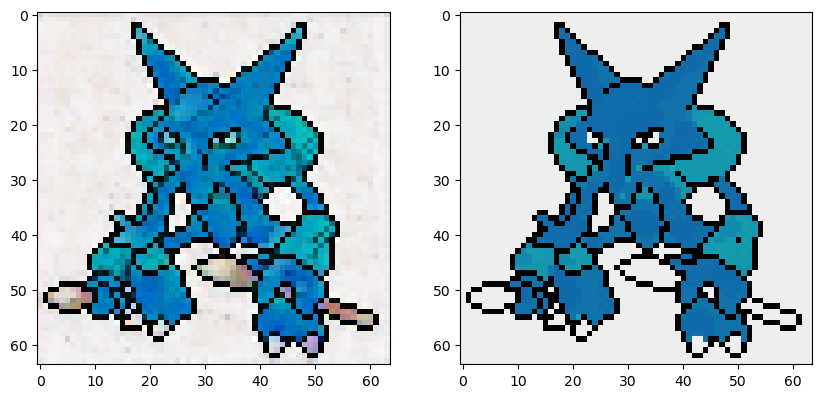

Epoch 60. Loss: 0.1540: 100%|██████████| 46/46 [00:01<00:00, 30.79it/s]


0.07172


Epoch 61. Loss: 0.0357: 100%|██████████| 46/46 [00:01<00:00, 30.13it/s]


0.06666


Epoch 62. Loss: 0.0803: 100%|██████████| 46/46 [00:01<00:00, 29.24it/s]


0.05551


Epoch 63. Loss: 0.0625: 100%|██████████| 46/46 [00:01<00:00, 31.99it/s]


0.06404


Epoch 64. Loss: 0.1016: 100%|██████████| 46/46 [00:01<00:00, 30.74it/s]


0.06133


Epoch 65. Loss: 0.0430: 100%|██████████| 46/46 [00:01<00:00, 31.62it/s]


0.05619


Epoch 66. Loss: 0.0728: 100%|██████████| 46/46 [00:01<00:00, 30.98it/s]


0.06933


Epoch 67. Loss: 0.0676: 100%|██████████| 46/46 [00:01<00:00, 27.57it/s]


0.06234


Epoch 68. Loss: 0.0676: 100%|██████████| 46/46 [00:01<00:00, 29.24it/s]


0.05277


Epoch 69. Loss: 0.0646: 100%|██████████| 46/46 [00:01<00:00, 29.43it/s]


0.07771


Epoch 70. Loss: 0.0689: 100%|██████████| 46/46 [00:01<00:00, 28.99it/s]


0.06080


Epoch 71. Loss: 0.0755: 100%|██████████| 46/46 [00:01<00:00, 29.53it/s]


0.06209


Epoch 72. Loss: 0.0550:  98%|█████████▊| 45/46 [00:01<00:00, 29.10it/s]


KeyboardInterrupt: 

In [8]:
model.train()

mse_loss = nn.MSELoss()
loss_fn = lambda output, target: mse_loss(output, target) + 2 * ssim_loss(output, target)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

epochs = 500
patience = 30

best_loss = torch.inf
best_model = copy.deepcopy(model.state_dict())
pat_count = 0

val_losses = []

for i in range(epochs):
    model.train()

    # Train
    pbar = tqdm(train_dl)
    for data in pbar:
        optimizer.zero_grad()
        
        data = data.to(device)
        data = data.view(data.shape[0], 2, 3, 64, 64)
        data = torch.stack([train_transform1(x) for x in data])

        im = data[:, 0]
        lb = data[:, 1]

        im = torch.stack([train_transform2(x) for x in im])

        out = model(im, 1)
        loss = loss_fn(out, lb).mean()
        pbar.set_description(f"Epoch {i}. Loss: {loss:.4f}", refresh=False)
        
        loss.backward()
        optimizer.step()
    
    with torch.no_grad():
        model.eval()

        data = next(iter(val_dl)).to(device)
        data = data.view(data.shape[0], 2, 3, 64, 64)
        data = torch.stack([train_transform1(x) for x in data])

        im = data[:, 0]
        lb = data[:, 1]

        im = torch.stack([train_transform2(x) for x in im])

        out = model(im, 1)
        loss = loss_fn(out, lb).mean()

        if loss <= best_loss:
            best_loss = loss
            best_model = copy.deepcopy(model.state_dict())
            pat_count = 0
            print(f'{loss:.5f} *')

            fig, axes = plt.subplots(1, 2, figsize=(10, 8))
            axes[0].imshow(out[0].permute(1, 2, 0).cpu().numpy(), vmin=0, vmax=1)
            axes[1].imshow(lb[0].permute(1, 2, 0).cpu().numpy(), vmin=0, vmax=1)
            plt.show()
        else:
            print(f'{loss:.5f}')

        val_losses.append(loss)

        pat_count = pat_count + 1
        if pat_count == patience:
            print("Patience ended.")
            break

model.load_state_dict(best_model)